## Review Response to Manually Craft Similarity Scoore

In [1]:
import numpy as np
import pandas as pd
import json
import pickle
import dataclasses
from dataclasses import dataclass, fields, _MISSING_TYPE
from heapq import heappush, heappop, heappushpop
from collections import OrderedDict
import math
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
from entropy_calculation import uncertainty
from sentence_transformers import SentenceTransformer
from numpy.linalg import norm
from scipy.spatial.distance import cityblock, minkowski, jaccard
import yake
from copy import deepcopy
from similarity_utils import SimilarityScore
import sys
sys.path.append("../")
from state_utils import get_spacy_info, get_llm_info, align_llm_spacy_output, get_model_state, StateOverview
# import state

In [2]:
# load sample response from datasets
load_path = "/Users/jiayangsong/Documents/git/LLM_analysis/hallucination_detection/response_data/"
dataset_name = "reponse_wiki_qa_train_new_200_400_.json"

df = pd.read_json(load_path+dataset_name)

print(f"dataset name: {dataset_name} \n" + 
      f"num of questions: {len(df)} \n" +
      f"dataset keys: {list(df.columns)} \n\n")

# take first reponse for later processing 
sample_response = df.iloc[23]

# extract response info 
num_token_response = sample_response["completion_tokens"]
top_k_prob = np.array(sample_response["top_k_prob"])
top_k_token = np.array(sample_response["top_k_token"])
top_logprobs = sample_response["top_logprobs"]
question = sample_response["question"]
text = sample_response["text"]
llm_token = sample_response["token"]
nlp = spacy.load("en_core_web_lg")
doc = nlp(text)
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

dataset name: reponse_wiki_qa_train_new_200_400_.json 
num of questions: 200 
dataset keys: ['question', 'answer', 'prompt', 'text', 'token', 'top_k_token', 'top_k_prob', 'top_logprobs', 'prompt_tokens', 'completion_tokens', 'response'] 




In [3]:
# for i in range(200, 400):
#     question = df.loc[i]['question']
#     response = repr(df.loc[i]['text'])
#     answer = repr(df.loc[i]['answer'])
#     vec_1, vec_2 = model.encode([response, answer])
#     similariy = np.dot(vec_1, vec_2)/(norm(vec_1)*norm(vec_2))
#     print(f"Index: {i}, \nSimilarity socre: {similariy}\n")
#     print(
#           # f"Here is a question and an answer, find any mistakes in the answer \n" + 
#           f"Question: {question} \n" + 
#           f"Answer: \n{response} \n\n"
#           f"Answer: \n{answer} \n\n\n"
#           )

In [8]:
# for i in range(200, 400):
#     question = df.loc[i]['question']
#     response = repr(df.loc[i]['text'])
#     answer = repr(df.loc[i]['answer'])
#     vec_1, vec_2 = model.encode([response, answer])
#     similariy = np.dot(vec_1, vec_2)/(norm(vec_1)*norm(vec_2))
#     if similariy < 0.7:
#       print(f"Index: {i}, \nSimilarity socre: {similariy}\n")
#       print(f"Here is a question and an answer, find any mistakes in the answer \n" + 
#             # f"Index: {i} \n" + 
#             f"Question: {question} \n" + 
#             f"Answer: \n{response} \n\n")
#         #   f"Answer: \n{answer} \n\n\n"
#         #   )
    

In [20]:
# load sample response from datasets
load_path = "../hallucination_detection/response_data/"
wiki_path = "reponse_wiki_qa_train_new_179.json"
eli5_fin_path = "reponse_eli5_final_train_200.json"
eli5_cat_path = "reponse_eli5_category_train_100.json"

wiki_qa_risky_index = [18, 23, 40, 44, 58, 101, 139] # reponse_wiki_qa_train_new_179
eli5_final_risky_index = [13, 96, 155, 186]  # reponse_eli5_final_train_200
eli5_category_risky_index = [6, 24] # reponse_eli5_category_train_100

df_wiki = pd.read_json(load_path + wiki_path)
df_eli5_fin = pd.read_json(load_path + eli5_fin_path)
df_eli5_cat = pd.read_json(load_path + eli5_cat_path)

wiki_risk_response = df_wiki.loc[wiki_qa_risky_index]
eli5_fin_risk_response = df_eli5_fin.loc[eli5_final_risky_index]
eli5_cat_risk_response = df_eli5_cat.loc[eli5_category_risky_index]

risk_response_df = pd.concat([wiki_risk_response, eli5_fin_risk_response, eli5_cat_risk_response], ignore_index=True)
risk_response_states = []

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
nlp = spacy.load("en_core_web_lg")

for i in range(risk_response_df.shape[0]):

    # take first reponse for later processing 
    sample_response = risk_response_df.loc[i]

    # extract response info 
    num_token_response = sample_response["completion_tokens"]
    top_k_prob = np.array(sample_response["top_k_prob"])
    top_k_token = np.array(sample_response["top_k_token"])
    top_logprobs = sample_response["top_logprobs"]
    question = sample_response["question"]
    text = sample_response["text"]
    llm_token = sample_response["token"]
    # state construction
    doc = nlp(text)
    nlp_result = get_spacy_info(doc)
    llm_result = get_llm_info(text, llm_token, top_k_prob, top_k_token)
    align_result = align_llm_spacy_output(nlp_result, llm_result, verbose=False)
    states = get_model_state(align_result)

    # if state is a the first state in a new sentence, reduce its entropy by 20%
    for i, state in enumerate(states[:-1]):
        if states[i-1].spacy_info["new_sentence"] == True:
                states[i].entropy *= 0.4

        # if state,pos_tag is important given extra attention
        if state.prop_tag.pos_tag in set(["NOUN", "VERB", "NUM"]):
                states[i].entropy *= 1.3

    final_states = StateOverview(states, 4, ("NOUN", "VERB"), 0.3, "sentence", nlp)

    # load embedding model
    weights= {"void":0}
    # compute state score
    scored_states = SimilarityScore(sample_response['text'], sample_response['answer'],
                                    final_states, nlp, model, weights)
    risk_response_states.append(scored_states)
    

/Users/jiayangsong/Documents/git/LLM_analysis/hallucination_detection/state_utils.py:117: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  alter_token_score.append(self.nlp_model(state.token).similarity(self.nlp_model(token)))


In [133]:
risk_entropy = []
risk_prob = []
risk_token_cos = []
risk_alter_toekn_sim_score = []
risk_alter_toekn_pos_score = []
risk_moving_entropy = []
risk_moving_entropy_rmse = []
risk_moving_entropy_tag = []

for response in risk_response_states:
    risk_entropy += [state.entropy for state in response.final_states.states]
    risk_prob += [state.probability for state in response.final_states.states]
    risk_token_cos += [score["cosine"] for score in response.token_score]
    risk_alter_toekn_sim_score += response.alter_token_sim_score
    risk_alter_toekn_pos_score += response.alter_token_pos_score
    
    for state in response.final_states.states:
        try:
            risk_moving_entropy.append(state.statistics.moving_mean["sentence_entropy"])
            risk_moving_entropy_rmse.append(state.statistics.moving_rmse["sentence_entropy"])
            risk_moving_entropy_tag.append(state.statistics.moving_mean["tag_entropy"])
        except:
            risk_moving_entropy.append(0)
            risk_moving_entropy_rmse.append(0)
            risk_moving_entropy_tag.append(0)


In [175]:
normal_states = []
for i in range(50):
    if i%10 == 0: print(i)
    try:
        response = df_wiki.iloc[i]
        nlp_result = get_spacy_info(nlp(response["text"]))
        llm_result = get_llm_info(response["text"], response["token"], np.array(response["top_k_prob"]), np.array(response["top_k_token"]))
        align_result = align_llm_spacy_output(nlp_result, llm_result, verbose=False)
        states = get_model_state(align_result)
        # if state is a the first state in a new sentence, reduce its entropy by 20%
        for i, state in enumerate(states[:-1]):
            if states[i-1].spacy_info["new_sentence"] == True:
                    states[i].entropy *= 0.4

            # if state,pos_tag is important given extra attention
            if state.prop_tag.pos_tag in set(["NOUN", "VERB", "NUM"]):
                    states[i].entropy *= 1.3
        final_states = StateOverview(states, 4, ("NOUN", "VERB"), 0.3, "sentence", nlp)
        scored_states = SimilarityScore(response['text'], response['answer'], final_states, nlp, model, weights)
        normal_states.append(scored_states)
    except:
        normal_states.append([])
        print(f"Error encountered at: {i}")

0


/Users/jiayangsong/Documents/git/LLM_analysis/hallucination_detection/state_utils.py:117: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  alter_token_score.append(self.nlp_model(state.token).similarity(self.nlp_model(token)))


10
20
30
40


In [176]:
normal_entropy = []
normal_prob = []
normal_token_cos = []
normal_alter_toekn_sim_score = []
normal_alter_toekn_pos_score = []
normal_moving_entropy = []
normal_moving_entropy_rmse = []
normal_moving_entropy_tag = []

for response in normal_states:
    try:
        normal_entropy += [state.entropy for state in response.final_states.states]
        normal_prob += [state.probability for state in response.final_states.states]
        normal_token_cos += [score["cosine"] for score in response.token_score]
        normal_alter_toekn_sim_score += response.alter_token_sim_score
        normal_alter_toekn_pos_score += response.alter_token_pos_score
    except:
        continue
    
    for state in response.final_states.states:
        try:
            normal_moving_entropy.append(state.statistics.moving_mean["sentence_entropy"])
            normal_moving_entropy_rmse.append(state.statistics.moving_rmse["sentence_entropy"])
            normal_moving_entropy_tag.append(state.statistics.moving_mean["tag_entropy"])
        except:
            normal_moving_entropy.append(0)
            normal_moving_entropy_rmse.append(0)
            normal_moving_entropy_tag.append(0)

Text(0.5, 0, 'Moving Entropy POS Tag (window=4)')

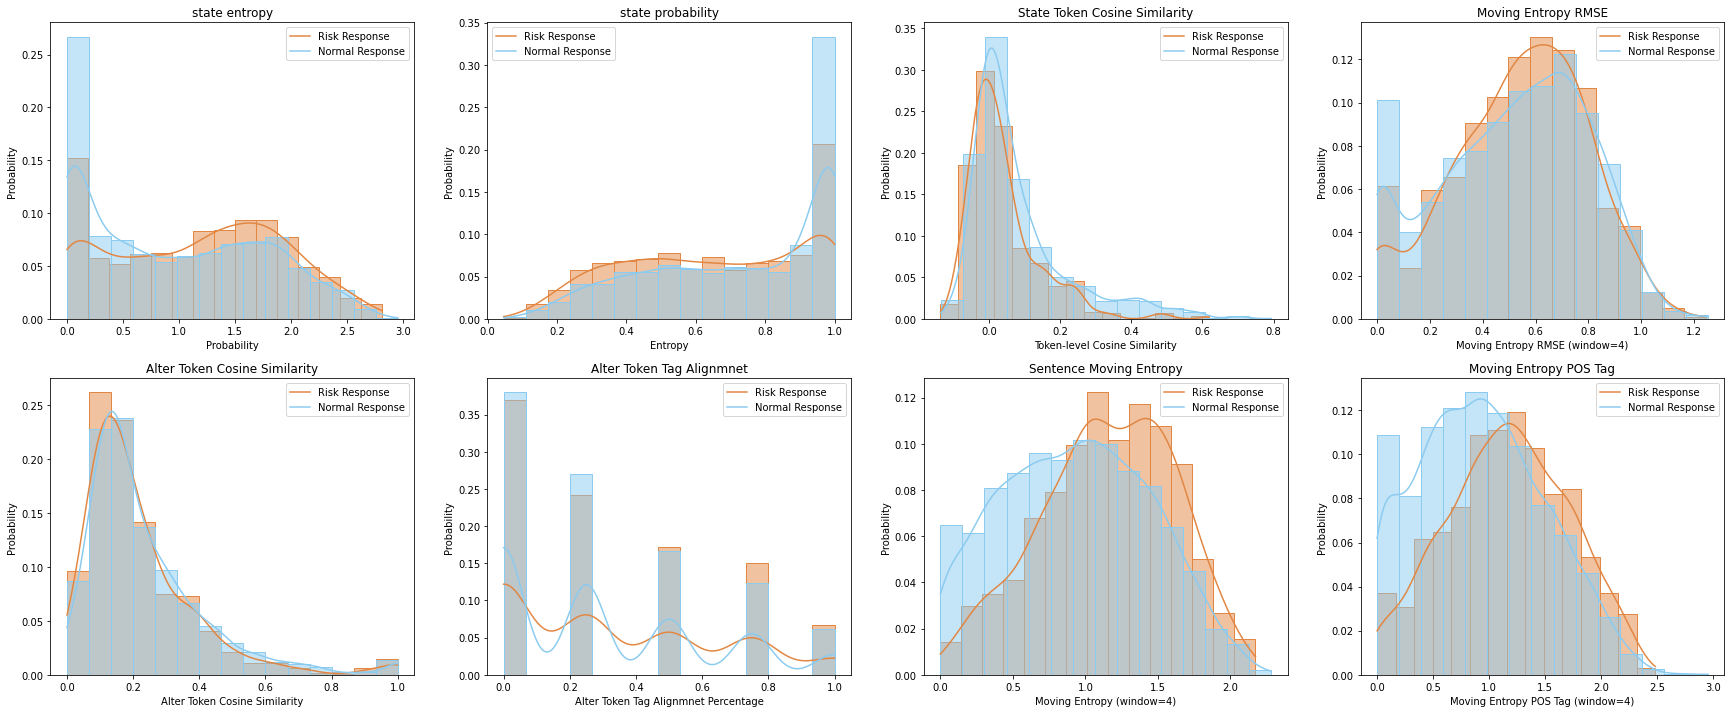

In [183]:
import seaborn as sns
fig, axes = plt.subplots(2, 4, figsize=(30, 12), sharey=False)

#create histogram with density curve overlaid
sns.histplot(risk_entropy, kde=True, bins=15, stat="probability", ax=axes[0,0],color='#e28743', edgecolor='#e28743')
sns.histplot(normal_entropy, kde=True, bins=15, stat="probability", ax=axes[0,0],color='#8bcbf0', edgecolor='#8bcbf0')
axes[0,0].set_title("state entropy")
axes[0,0].legend(labels=['Risk Response', 'Normal Response'])
axes[0,0].set_xlabel("Probability")

sns.histplot(risk_prob, kde=True, bins=15, stat="probability",ax=axes[0,1],color='#e28743', edgecolor='#e28743')
sns.histplot(normal_prob, kde=True, bins=15, stat="probability", ax=axes[0,1],color='#8bcbf0', edgecolor='#8bcbf0')
axes[0,1].set_title("state probability")
axes[0,1].legend(labels=['Risk Response', 'Normal Response'])
axes[0,1].set_xlabel("Entropy")

sns.histplot(risk_token_cos, kde=True, bins=15, stat="probability",ax=axes[0, 2],color='#e28743', edgecolor='#e28743')
sns.histplot(normal_token_cos, kde=True, bins=15, stat="probability", ax=axes[0,2],color='#8bcbf0', edgecolor='#8bcbf0')
axes[0,2].set_title("State Token Cosine Similarity")
axes[0,2].legend(labels=['Risk Response', 'Normal Response'])
axes[0,2].set_xlabel("Token-level Cosine Similarity")

sns.histplot(risk_moving_entropy_rmse, kde=True, bins=15, stat="probability",ax=axes[0, 3],color='#e28743', edgecolor='#e28743')
sns.histplot(normal_moving_entropy_rmse, kde=True, bins=15, stat="probability", ax=axes[0,3],color='#8bcbf0', edgecolor='#8bcbf0')
axes[0,3].set_title("Moving Entropy RMSE")
axes[0,3].legend(labels=['Risk Response', 'Normal Response'])
axes[0,3].set_xlabel("Moving Entropy RMSE (window=4)")

sns.histplot(risk_alter_toekn_sim_score, kde=True, bins=15, stat="probability",ax=axes[1,0],color='#e28743', edgecolor='#e28743')
sns.histplot(normal_alter_toekn_sim_score, kde=True, bins=15, stat="probability", ax=axes[1,0],color='#8bcbf0', edgecolor='#8bcbf0')
axes[1,0].set_title("Alter Token Cosine Similarity")
axes[1,0].legend(labels=['Risk Response', 'Normal Response'])
axes[1,0].set_xlabel("Alter Token Cosine Similarity")

sns.histplot(risk_alter_toekn_pos_score, kde=True, bins=15, stat="probability",ax=axes[1,1],color='#e28743', edgecolor='#e28743')
sns.histplot(normal_alter_toekn_pos_score, kde=True, bins=15, stat="probability", ax=axes[1,1],color='#8bcbf0', edgecolor='#8bcbf0')
axes[1,1].set_title("Alter Token Tag Alignmnet")
axes[1,1].legend(labels=['Risk Response', 'Normal Response'])
axes[1,1].set_xlabel("Alter Token Tag Alignmnet Percentage")

sns.histplot(risk_moving_entropy, kde=True, bins=15, stat="probability",ax=axes[1,2],color='#e28743', edgecolor='#e28743')
sns.histplot(normal_moving_entropy, kde=True, bins=15, stat="probability", ax=axes[1,2],color='#8bcbf0', edgecolor='#8bcbf0')
axes[1,2].set_title("Sentence Moving Entropy")
axes[1,2].legend(labels=['Risk Response', 'Normal Response'])
axes[1,2].set_xlabel("Moving Entropy (window=4)")

sns.histplot(risk_moving_entropy_tag, kde=True, bins=15, stat="probability",ax=axes[1,3],color='#e28743', edgecolor='#e28743')
sns.histplot(normal_moving_entropy_tag, kde=True, bins=15, stat="probability", ax=axes[1,3],color='#8bcbf0', edgecolor='#8bcbf0')
axes[1,3].set_title("Moving Entropy POS Tag")
axes[1,3].legend(labels=['Risk Response', 'Normal Response'])
axes[1,3].set_xlabel("Moving Entropy POS Tag (window=4)")


In [112]:
# take first reponse for later processing 
sample_response = df.iloc[139]

# extract response info 
num_token_response = sample_response["completion_tokens"]
top_k_prob = np.array(sample_response["top_k_prob"])
top_k_token = np.array(sample_response["top_k_token"])
top_logprobs = sample_response["top_logprobs"]
question = sample_response["question"]
text = sample_response["text"]
llm_token = sample_response["token"]
# state construction
nlp = spacy.load("en_core_web_lg")
doc = nlp(text)
nlp_result = get_spacy_info(doc)
llm_result = get_llm_info(text, llm_token, top_k_prob, top_k_token)
align_result = align_llm_spacy_output(nlp_result, llm_result, verbose=False)
states = get_model_state(align_result)

# if state is a the first state in a new sentence, reduce its entropy by 20%
for i, state in enumerate(states[:-1]):
      if states[i-1].spacy_info["new_sentence"] == True:
            states[i].entropy *= 0.4

      # if state,pos_tag is important given extra attention
      if state.prop_tag.pos_tag in set(["NOUN", "VERB", "NUM"]):
            states[i].entropy *= 1.3

final_states = StateOverview(states, 4, ("NOUN", "VERB"), 0.3, "sentence", nlp)

# load embedding model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
weights= {"void":0}
# compute state score
scored_states = SimilarityScore(sample_response['text'], sample_response['answer'],
                                final_states, nlp, model, weights)

# display question, response from llm,  true answer
print(f"Question: {sample_response['question']} \n\n" + 
      f"Response: {repr(''.join((sample_response['text'])))} \n\n" + 
      f"Answer: {repr(''.join((sample_response['answer'])))} \n")

Question: how long did the roman empire last 

Response: '?\n\nThe Roman Empire lasted for over 1,500 years, from its founding in 27 BC to its fall in 476 AD. During this time, the Roman Empire grew to become one of the largest and most powerful empires in history, stretching from Britain to the Middle East and North Africa. Its legacy can still be seen today in the form of the Latin language, Roman law, and the many monuments and ruins that still stand throughout Europe.' 

Answer: 'The 500-year-old Roman Republic , which preceded it, had been destabilized through a series of civil wars .' 



In [119]:
# sentence similarity
sentence_sim_list = scored_states.sentence_score
sentence_cosine = np.zeros(len(final_states.states))
sentence_euclidean = sentence_cosine.copy()

state_prob = [state.probability for state in final_states.states]
sentence_mean_prob = [state.statistics.moving_mean["sentence_prob"] for state in final_states.states]
sentence_mean_entropy = [state.statistics.moving_mean["sentence_entropy"] for state in final_states.states]

token_cosine = [toekn_score["cosine"] for toekn_score in scored_states.token_score]
keyword_score = scored_states.keyword_score
alter_token_sim_score = scored_states.alter_token_sim_score
alter_token_pos_score = scored_states.alter_token_pos_score

sentence_weighted_mean_entropy = [state.statistics.weighted_moving_mean["sentence_entropy"] for state in final_states.states]
sentence_weighted_tag_mean_entropy = [state.statistics.weighted_moving_mean["tag_entropy"] for state in final_states.states]

start_index = 0
for i, end_index in enumerate(scored_states.final_states.end_state_index):
    sentence_cosine[start_index:end_index] = scored_states.sentence_score[i]["cosine"]
    sentence_euclidean[start_index:end_index] = scored_states.sentence_score[i]["euclidean"]
    start_index = end_index

state_text = [state.token for state in final_states.states]
state_probability = [state.probability for state in final_states.states]
state_entropy = [state.entropy for state in final_states.states]
state_count = np.arange(len(state_text))
plot_colors = ['hotpink','darkviolet','mediumblue', 'purple', 'brown']

target_tag = set(["NOUN", "VERB"])
select_state = []

for state in final_states.states:
    if state.prop_tag.pos_tag in target_tag:
        select_state.append(state)

select_state_index = [int(state.idx) for state in select_state]
select_state_text = [state.token for state in select_state]
select_state_probability = [state.probability for state in select_state]
select_state_entropy = [state.entropy for state in select_state]
select_state_count = np.arange(len(select_state_text))

select_state_entropy = [state_entropy[i] for i in select_state_index]
select_weight_sentence_mean_prob = [state.statistics.weighted_moving_mean["sentence_prob"] for state in select_state]
select_weight_sentence_mean_entropy = [state.statistics.weighted_moving_mean["sentence_entropy"] for state in select_state]
select_token_cosine =[token_cosine[i] for i in select_state_index]
select_keyword_score = [keyword_score[i] for i in select_state_index]
select_alter_token_sim_score = [alter_token_sim_score[i] for i in select_state_index]
select_alter_token_pos_score = [alter_token_pos_score[i] for i in select_state_index]

sentence_rmse_entropy = [state.statistics.moving_rmse["sentence_entropy"] for state in final_states.states]
weight_sentence_rmse_entropy = [state.statistics.weighted_moving_rmse["sentence_entropy"] for state in final_states.states]
doc_median_entropy = [state.statistics.moving_doc_median["entropy"] for state in final_states.states]
state_tag_mean_entropy  = [state.statistics.moving_mean["tag_entropy"] for state in final_states.states]

In [114]:
rmse_activation = np.zeros(len(weight_sentence_rmse_entropy))
rmse_threshold = np.mean(np.array_split(np.sort(weight_sentence_rmse_entropy)[::-1],3)[0])
for i, rmse in enumerate(weight_sentence_rmse_entropy[1:-1]):
    if rmse > rmse_threshold:
        rmse_activation[i] = 1

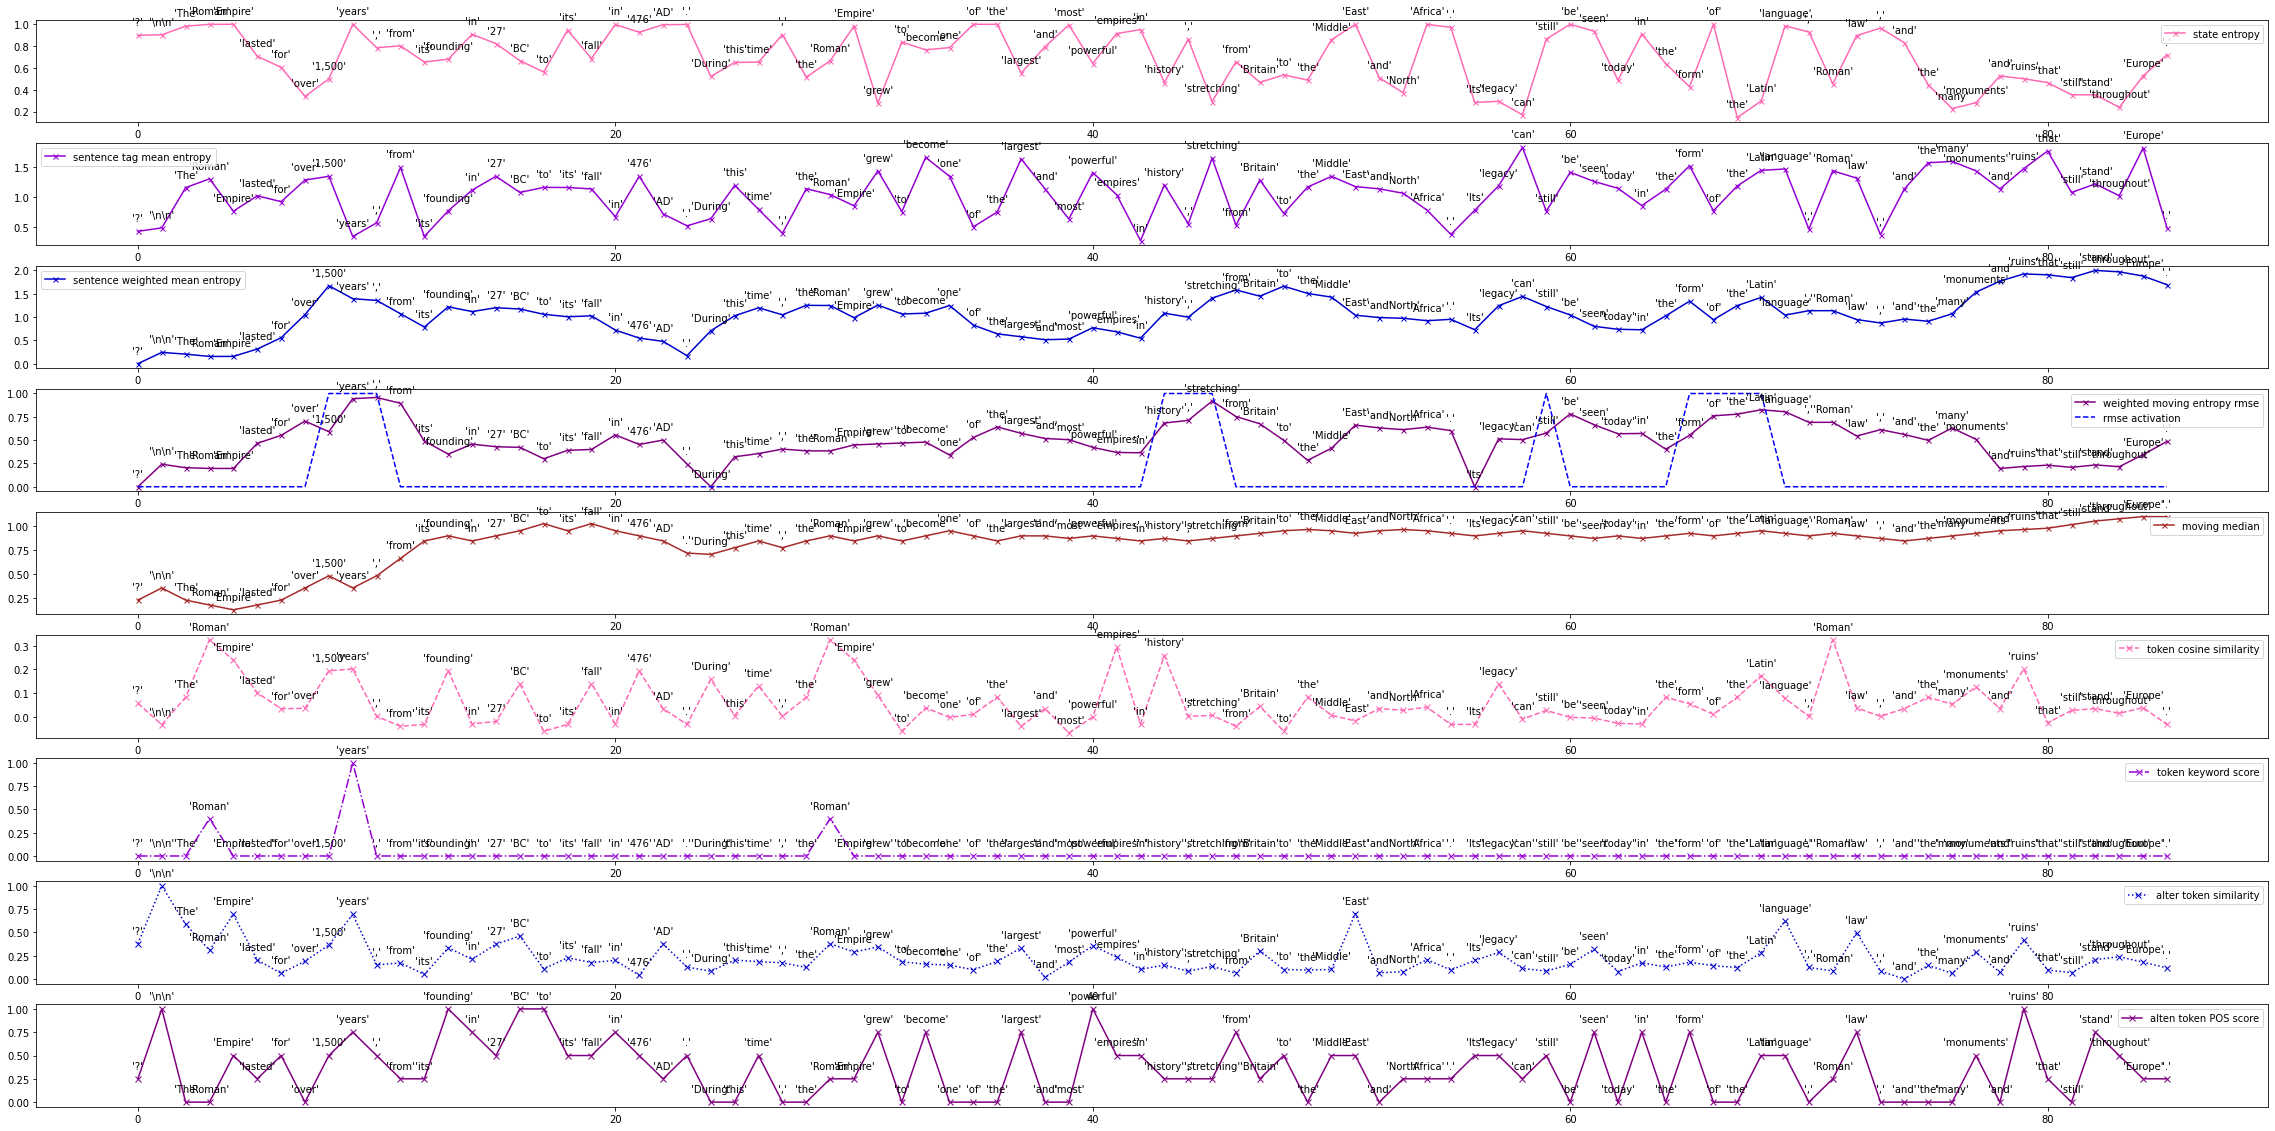

In [120]:
token_cosine = [toekn_score["cosine"] for toekn_score in scored_states.token_score]
keyword_score = scored_states.keyword_score
alter_token_sim_score = scored_states.alter_token_sim_score
alter_token_pos_score = scored_states.alter_token_pos_score

fig, axs = plt.subplots(9, 1, figsize=(40, 20))

axs[0].plot(state_count, state_prob, marker="x", markersize=5, c=plot_colors[0], label="state entropy")
# axs[0].plot(state_count, sentence_cosine, '--', c="b", label="sentence cosine similarity")
axs[1].plot(state_count, sentence_weighted_tag_mean_entropy, marker="x", markersize=5, c=plot_colors[1], label="sentence tag mean entropy")
axs[2].plot(state_count, sentence_weighted_mean_entropy, marker="x", markersize=5, c=plot_colors[2], label="sentence weighted mean entropy")
axs[3].plot(state_count, weight_sentence_rmse_entropy, marker="x", markersize=5, c=plot_colors[3], label="weighted moving entropy rmse")
axs[3].plot(state_count, rmse_activation, '--', c="b", label="rmse activation")
axs[4].plot(state_count, doc_median_entropy, marker="x", markersize=5, c=plot_colors[4], label="moving median")
axs[5].plot(state_count, token_cosine,'--', marker="x", c=plot_colors[0], label="token cosine similarity")
axs[6].plot(state_count, keyword_score, '-.', marker="x", c=plot_colors[1], label="token keyword score")
axs[7].plot(state_count, alter_token_sim_score, ':', marker="x", c=plot_colors[2], label="alter token similarity")
axs[8].plot(state_count, alter_token_pos_score, marker="x", c=plot_colors[3], label="alten token POS score")

# zip joins x and y coordinates in pairs
for index, value in enumerate([state_prob, sentence_weighted_tag_mean_entropy, sentence_weighted_mean_entropy, weight_sentence_rmse_entropy, doc_median_entropy,
                                token_cosine, keyword_score, alter_token_sim_score, alter_token_pos_score]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(state_count, value):

        label = repr(state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
        axs[index].legend()
plt.show()

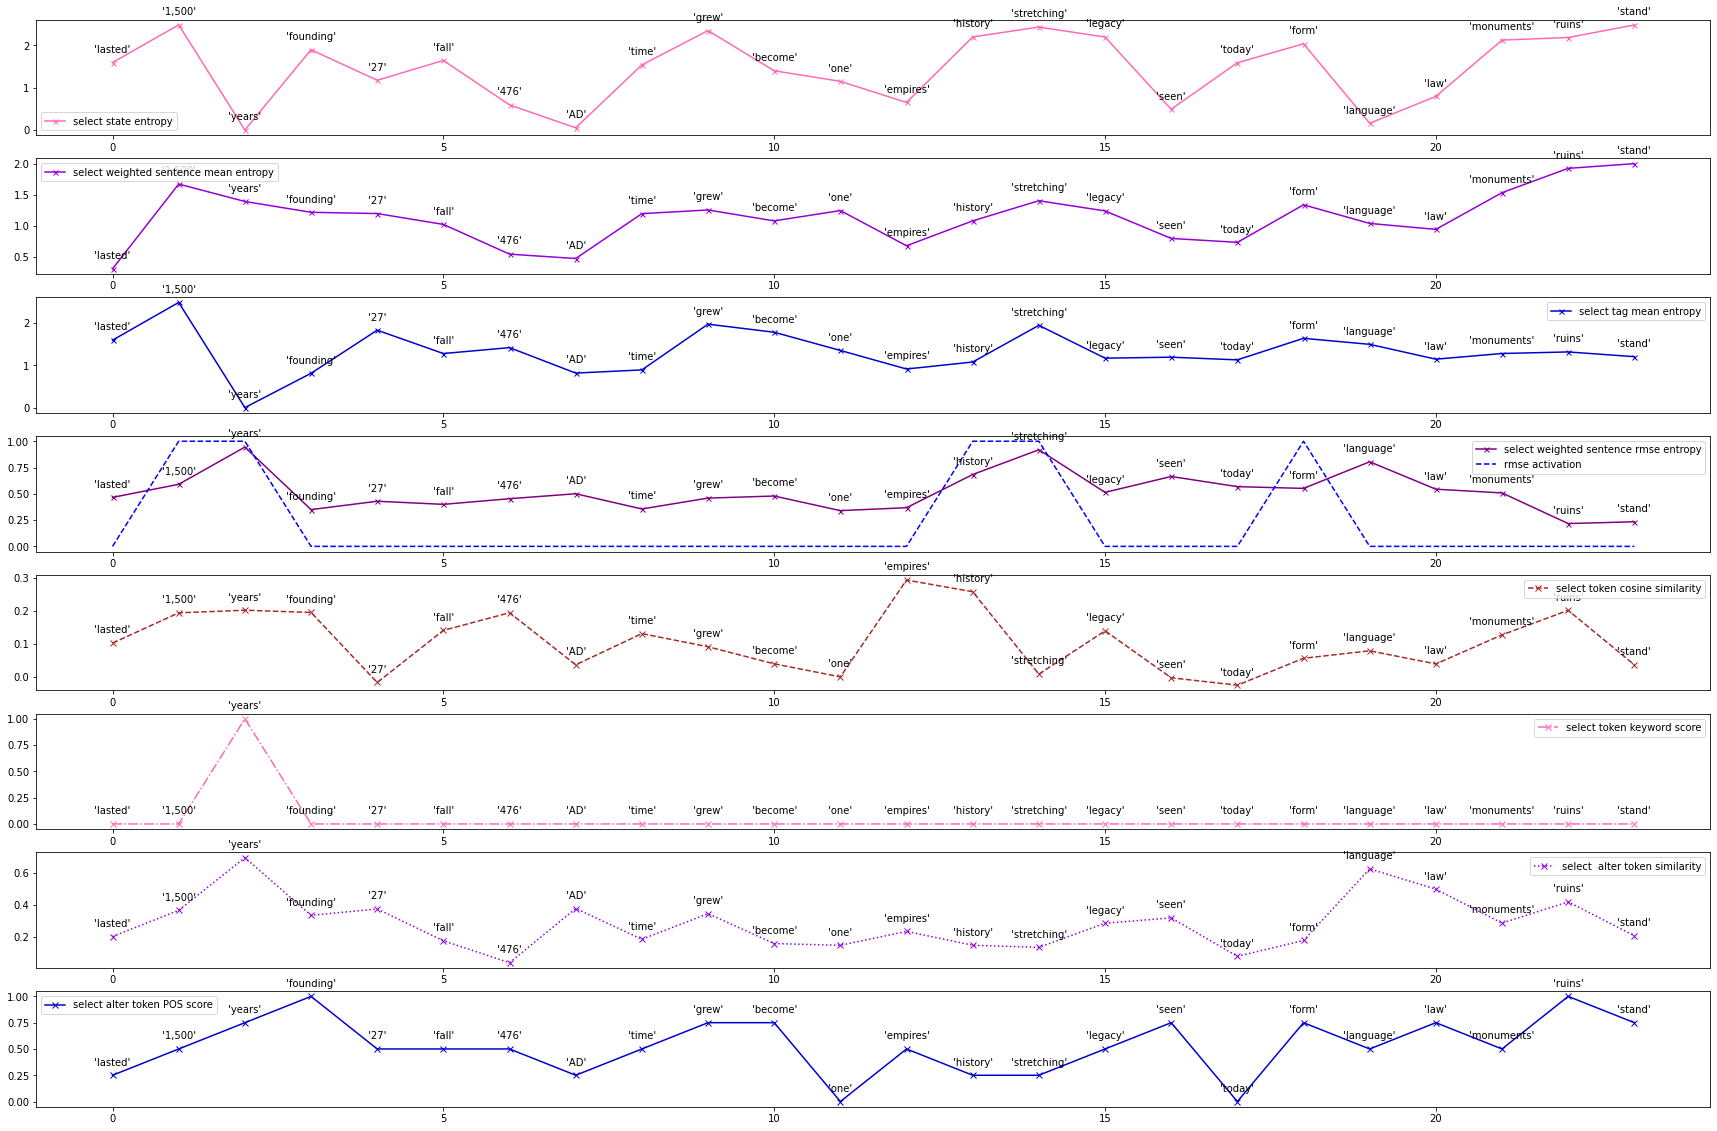

In [123]:
target_tag = set(["NOUN", "VERB", "NUM"])
select_state = []
select_rmse_activation = []

for i, state in enumerate(final_states.states):
    if state.prop_tag.pos_tag in target_tag:
        select_state.append(state)
        select_rmse_activation.append(rmse_activation[i])        

select_state_index = [int(state.idx) for state in select_state]
select_state_text = [state.token for state in select_state]
select_state_probability = [state.probability for state in select_state]
select_state_entropy = [state.entropy for state in select_state]
select_state_count = np.arange(len(select_state_text))

select_state_entropy = [state_entropy[i] for i in select_state_index]
select_weight_sentence_mean_prob = [state.statistics.weighted_moving_mean["sentence_prob"] for state in select_state]
select_weight_sentence_mean_entropy = [state.statistics.weighted_moving_mean["sentence_entropy"] for state in select_state]

select_state_tag_mean_entropy  = [state.statistics.moving_mean["tag_entropy"] for state in select_state]
select_weight_sentence_rmse_entropy = [state.statistics.weighted_moving_rmse["sentence_entropy"] for state in select_state]

select_token_cosine =[token_cosine[i] for i in select_state_index]
select_keyword_score = [keyword_score[i] for i in select_state_index]
select_alter_token_sim_score = [alter_token_sim_score[i] for i in select_state_index]
select_alter_token_pos_score = [alter_token_pos_score[i] for i in select_state_index]


fig, axs = plt.subplots(8, 1, figsize=(30, 20))

axs[0].plot(select_state_count, select_state_entropy, marker="x", markersize=5, c=plot_colors[0], label="select state entropy")
axs[1].plot(select_state_count, select_weight_sentence_mean_entropy, marker="x", markersize=5, c=plot_colors[1], label="select weighted sentence mean entropy")
axs[2].plot(select_state_count, select_state_tag_mean_entropy, marker="x", markersize=5, c=plot_colors[2], label="select tag mean entropy")
axs[3].plot(select_state_count, select_weight_sentence_rmse_entropy, marker="x", markersize=5, c=plot_colors[3], label="select weighted sentence rmse entropy")
axs[3].plot(select_state_count, select_rmse_activation, '--', c="b", label="rmse activation")

axs[4].plot(select_state_count, select_token_cosine,'--', marker="x", c=plot_colors[4], label="select token cosine similarity")
axs[5].plot(select_state_count, select_keyword_score, '-.', marker="x", c=plot_colors[0], label="select token keyword score")
axs[6].plot(select_state_count, select_alter_token_sim_score, ':', marker="x", c=plot_colors[1], label="select  alter token similarity")
axs[7].plot(select_state_count, select_alter_token_pos_score, marker="x", c=plot_colors[2], label="select alter token POS score")

# zip joins x and y coordinates in pairs
for index, value in enumerate([select_state_entropy, select_weight_sentence_mean_entropy, select_state_tag_mean_entropy,
                               select_weight_sentence_rmse_entropy, select_token_cosine, 
                               select_keyword_score, select_alter_token_sim_score, select_alter_token_pos_score]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(select_state_count, value):

        label = repr(select_state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
        axs[index].legend()
plt.show()
